## IMDB review sentiment Analysis


#### Μέλη Ομάδας:
- Ευάγγελος Λευτάκης : 3200093
- Ρέα Σκλήκα : 3210181
- Σοφία-Ζωή Σωτηρίου : 3210192

### Dependencies

In [18]:
# %pip install -U pandas
# %pip install -U numpy
# %pip install -U scipy
# %pip install -U tensorflow
# %pip install -U scikit-learn
#%pip install -U pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten, Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

%matplotlib inline

### Part 1

#### Data Preperation
First We Prepare the train and test data and create a binary representation of it.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

(x_train_imdb, y_train), (x_test_imdb, y_test) = tf.keras.datasets.imdb.load_data()


word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train_imdb])
x_test_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test_imdb])

binary_vectorizer = CountVectorizer(binary=True, min_df=100,stop_words="english")
x_train = binary_vectorizer.fit_transform(x_train_imdb)
x_test = binary_vectorizer.transform(x_test_imdb)
print(
    'Vocabulary size:', len(binary_vectorizer.vocabulary_)
)
x_train = x_train.astype(int)
x_test = x_test.astype(int)

# x_train = x_train.toarray()
# x_test = x_test.toarray()



Vocabulary size: 3563


#### Logistic Regression:


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import issparse
from sklearn.metrics import classification_report

class LogisticRegression():
   

    def __init__(self,epochs=20,learning_rate=0.001,threshold=0.5, regularization_factor=1):
        self.epochs=epochs;
        self.learning_rate=learning_rate
        self.weights = np.array([])
        self.threshold=threshold
        self.regularization_factor = regularization_factor
        
    
    def set_threshold(self,value):
        self.threshold = value
    def sigmoid(self , t):
        return 1/(1+np.exp(-t))


    def fit(self,x_train_input,y_train_input,learning_curve=False):
        ''' '''
        feature_vector_length = x_train_input.shape[1]
        split_index = int(0.8 * x_train_input.shape[0])  # 80% for training, 20% for dev
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]
        x_dev = x_dev.toarray()
        

        training_learning_curve_data =[]
        dev_learning_curve_data = []

        # We prepare the array by adding a column of 1s
        # for the w0 weight
        x_train = x_train.toarray()
        ones_column = np.ones(x_train.shape[0])
        x_train = np.insert(x_train, 0, ones_column, axis=1)
        self.weights = self.initialize_weights(feature_vector_length)
        
        for epoch in range(self.epochs):
            suffled_indices = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[suffled_indices]
            y_train_shuffled = y_train[suffled_indices]
            for i in range(x_train.shape[0]):
                x_i = x_train_shuffled[i-1]
                y_i = y_train_shuffled[i-1]

                self.update_weights(x_i,y_i)
            if(learning_curve):
                x_train_temp = np.delete(x_train, 0, axis=1)
                training_learning_curve_data.append(accuracy_score(y_train,self.predict(x_train_temp)))
                dev_learning_curve_data.append(accuracy_score(y_dev,self.predict(x_dev)))
        x_train = np.delete(x_train, 0, axis=1)                 #remove 1s column again (needed previously for w0)

        return self.evaluate(y_train,self.predict(x_train)),training_learning_curve_data,dev_learning_curve_data


        
    
    def predict(self, x_test):
        if issparse(x_test):
            x_test = x_test.toarray()
        ones_column = np.ones(x_test.shape[0])
        x_test = np.insert(x_test, 0, ones_column, axis=1)#insert 1 in x_vector for w0

        y_test_predicted = []

        for test_case in x_test:
            probability_positive =  self.sigmoid(np.dot(self.weights,test_case))
            predicted_class = 1 if probability_positive >= self.threshold else 0
            y_test_predicted.append(predicted_class)

        x_test = np.delete(x_test, 0, axis=1)
        return np.array(y_test_predicted)

    def predict_prob(self, x_test):
        if issparse(x_test):
            x_test = x_test.toarray()
        ones_column = np.ones(x_test.shape[0])
        x_test = np.insert(x_test, 0, ones_column, axis=1)#insert 1 in x_vector for w0

        y_test_predicted = []

        for test_case in x_test:
            probability_positive =  self.sigmoid(np.dot(self.weights,test_case))
            y_test_predicted.append([probability_positive,(1-probability_positive)])
        x_test = np.delete(x_test, 0, axis=1)
        return np.array(y_test_predicted)


    @staticmethod
    def initialize_weights(size):
        '''We Initialize the weights with random values with a mean of 0 and a standard deviation of 0.01
          This is a common practice to prevent the weights from being too large at the begining '''
        return np.random.randn(size+1) * 0.01

    def update_weights(self,x_test,y_test):
        predicted_prob = self.sigmoid(np.dot(self.weights,x_test))
        gradient = ((y_test - predicted_prob) * x_test)
        self.weights = (1 - 2*self.regularization_factor*self.learning_rate) * self.weights + self.learning_rate * gradient 
    
    def evaluate(self, y_true, y_predicted):
        precision = precision_score(y_true, y_predicted)
        recall = recall_score(y_true, y_predicted)
        f1 = f1_score(y_true, y_predicted)

        print(classification_report(y_true, y_predicted))
        print("Threshold: "+str(self.threshold))
        return np.array([precision,recall,f1])
    

##### Results
Here we try out the Logistic Regression learning algorithm

In [5]:
LogReg = LogisticRegression(100,threshold=0.6, regularization_factor=0.001)
LogReg.fit(x_train,y_train)
#LogReg.generate_pr_curves()
y_predicted = LogReg.predict(x_test)
LogReg.evaluate(y_test,y_predicted)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      9969
           1       0.94      0.86      0.90     10031

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Threshold: 0.6
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     12500
           1       0.90      0.82      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.87      0.86      0.86     25000
weighted avg       0.87      0.86      0.86     25000

Threshold: 0.6


array([0.90049487, 0.8152    , 0.85572724])

#### Naive Bayes:

In [14]:
import numpy as np
from math import log
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#

class NaiveBayes: 
    def __init__(self):
            self.probabilityC1= None #probabilityC0 = 1 -probabilityC1
            self.boundProbabilityC0 = None 
            self.boundProbabilityC1 = None

    def fit(self, x_train_input, y_train_input): 
        split_index = int(0.8 * x_train_input.shape[0])  # 80% for training, 20% for dev
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]
        
        # x_train = x_train_input
        # y_train = y_train_input

        numberOfExamples = x_train.shape[0]
        numberOfFeatures = x_train.shape[1]
        x_train = x_train.toarray()
        #y_train = y_train.flatten()

        #negativeReviews = 1 - positiveReviews
        positiveReviews = 0
        for label in y_train: 
            if label == 1: 
                positiveReviews += 1 
        self.probabilityC1 = positiveReviews / numberOfExamples

        '''
        C0: P( X(i) = 0 | C = 0) and C1 = P ( X(i) = 0 | C = 1)
        P( X(i) = 1 | C = 0) = 1 - P( X(i) = 0 | C = 0) and P( X(i) = 1 | C = 1) = P( X(i) = 0 | C = 1)
        '''
        self.boundProbabilityC0 = np.zeros(numberOfFeatures) 
        self.boundProbabilityC1 = np.zeros(numberOfFeatures)
        for i in range(numberOfFeatures): 
             # Laplace smoothing
            self.boundProbabilityC0[i] = 1
            self.boundProbabilityC1[i] = 1
            #For every word that is not on a review add to the array correspnding to the review result of the example
            for j in range(numberOfExamples):  
                if y_train[j] == 0 and x_train[j][i] == 0: 
                    self.boundProbabilityC0[i] += 1 
                elif y_train[j] == 1 and x_train[j][i] == 0: 
                    self.boundProbabilityC1[i] += 1 
        """
        Adding Laplace estimator with an alpha value of 1
        """
        self.boundProbabilityC0 = [(x + 1) / (numberOfExamples - positiveReviews + 2) for x in self.boundProbabilityC0] 
        
        self.boundProbabilityC1 = [(x + 1) / (positiveReviews + 2) for x in self.boundProbabilityC1]


    def predict(self, x_test):
        prediction = list()
        numberOfFeatures = x_test.shape[1]
        x_test = x_test.toarray()

        for x in x_test:
            positiveReviewProbability = log(self.probabilityC1)
            negativeReviewProbability = log(1 - self.probabilityC1)
            for y in range(numberOfFeatures): 
                if x[y] == 1:
                    if self.boundProbabilityC1[y] == 1: 
                        self.boundProbabilityC1[y] = 0.9999999999999999
                    positiveReviewProbability += log(1 - self.boundProbabilityC1[y])
                    negativeReviewProbability += log(1 - self.boundProbabilityC0[y])
                elif x[y] == 0: 
                    positiveReviewProbability += log(self.boundProbabilityC1[y])
                    negativeReviewProbability +=log(self.boundProbabilityC0[y])
            if positiveReviewProbability > negativeReviewProbability: 
                prob = 1
            elif negativeReviewProbability > positiveReviewProbability: 
                prob = 0

            prediction.append(prob)

        return np.array(prediction)

    
    def evaluate(self, y_true, y_predicted):
        accuracy = accuracy_score(y_true, y_predicted)
        print("Accuracy:", accuracy)

        precision = precision_score(y_true, y_predicted)
        print("Precision:", precision)

        # Compute recall
        recall = recall_score(y_true, y_predicted)
        print("Recall:", recall)

        # Compute F1 score
        f1 = f1_score(y_true, y_predicted)
        print("F1 Score:", f1)
        return np.array([precision,recall])
    



##### Results:

In [13]:
NB = NaiveBayes()
NB.fit(x_train,y_train)
y_predicted = NB.predict(x_test)

NB.evaluate(y_test,y_predicted)

Accuracy: 0.8412
Precision: 0.853707082434898
Recall: 0.82352
F1 Score: 0.8383418845182833


array([0.85370708, 0.82352   ])


#### [AdaBoost:](Machine-Learning-Algorithms/AdaBoost.py)

In [60]:
import numpy as np
import random as random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class AdaBoost:
    def __init__(self):
        self.M = None
        self.models = []
        self.weights = []
    
    def fit (self, x_train_input, y_train_input, M):
        split_index = int(0.8 * x_train_input.shape[0])  # 80% for training, 20% for dev
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]
        x_train = x_train.toarray()
    
        self.M = M
        # first all samples get the same weight, 1/total number of examples
        # that makes the samples all equally important
        sample_weights = np.ones(x_train.shape[0]) * (1 / x_train.shape[0])
        for m in range(M):
            stump = CreateStump()
            stump.fit( x_train, y_train, sample_weights)
            sample_weights = stump.weights
            self.models.append(stump)
            distribution = list(np.shape(sample_weights) )
            distribution[0] = sample_weights[0]
            for i in range (1,len(sample_weights)):
                distribution.append(distribution[i-1] + sample_weights[i])
            # make a new empty dataset the same size as the original and pick a random number [0..1]
            # and see where that number falls when the sample weights are use like a distribution
            # we fill the new dataset with those values 
            newDataset = np.zeros_like(x_train)
            temp_y = np.zeros_like(y_train)
            for i in range (x_train.shape[0]):
                number = random.random()
                for k in range (x_train.shape[0]):
                    if number <= distribution[k]:
                        for j in range (x_train.shape[1]):
                            newDataset[i][j] = x_train[k][j]
                        sample_weights[i] = sample_weights[k]
                        temp_y += y_train[k]
                        break 
            # normalize the weights so they all add up to 1
            sum = np.sum(sample_weights)
            for i in range(len(sample_weights)):
                self.weights.append( sample_weights[i]/sum) 
            x_train = np.copy(newDataset)
            y_train = np.copy(temp_y)
        y_dev_predicted = self.predict(x_dev)
        return self.evaluate(y_dev_predicted, y_dev)

    def predict(self, x_test):
        x_test = x_test.toarray()
        
        predictions = np.zeros(x_test.shape[0])
        stump_says = np.zeros(len(self.models))

        for i, stump in enumerate(self.models):
            # Get predictions from each stump
            stump_pred = stump.predict(x_test)
            stump_says[i] = stump.amountOfSay
            # Update overall predictions based on the stump's amount of say
            predictions += stump_pred * stump_says[i]

        # Final prediction is based on the sign of the weighted sum
        final_predictions = np.sign(predictions)

        return final_predictions
    
    def evaluate(self, y_true, y_predicted):
        nan_indices1 = np.isnan(y_true)
        if np.any(nan_indices1):
            # Handle NaN values (e.g., remove or replace them)
            y_true = np.nan_to_num(y_true)
        nan_indices2 = np.isnan(y_predicted)
        if np.any(nan_indices2):
            # Handle NaN values (e.g., remove or replace them)
            y_predicted = np.nan_to_num(y_predicted)
            
        accuracy = accuracy_score(y_true, y_predicted)
        print("Accuracy:", accuracy)

        precision = precision_score(y_true, y_predicted)
        print("Precision:", precision)

        # Compute recall
        recall = recall_score(y_true, y_predicted)
        print("Recall:", recall)

        # Compute F1 score
        f1 = f1_score(y_true, y_predicted)
        print("F1 Score:", f1)


            


class CreateStump:
    def __init__(self):
        self.amountOfSay = None
        self.word = None
        self.weights = []

    def fit(self, x, y, w):
        min = float('inf')
        for word_index in range(x.shape[1]):           
            total_error = 0         # the total error of a stump is the sum of the weights associated with the incorrectly classed samples
            cor_pos = 0             # correctly positive
            incor_pos = 0           # incorrectly positive
            cor_neg = 0             # correctly negative
            incor_neg = 0           # incorrectly negative
            for sample_index in range(x.shape[0]):
                if x[sample_index][word_index] == 1 & y[sample_index] == 1:
                    cor_pos += 1
                elif x[sample_index][word_index] == 1 & y[sample_index] == 0:
                    incor_pos += 1
                    total_error += w[sample_index]
                elif x[sample_index][word_index] == 0 & y[sample_index] == 0:
                    cor_neg += 1
                else:
                    incor_neg += 1
                    total_error += w[sample_index]
            pos_total = cor_pos + incor_pos
            neg_total = cor_neg + incor_neg
            total = x.shape[0]
            epsilon = 1e-10  # Small epsilon value to avoid division by zero
            gini_index = ((pos_total)/total)*(1-(cor_pos/(pos_total + epsilon))**2+(incor_pos/(pos_total + epsilon))**2)+((neg_total)/total)*(1-(cor_neg/(neg_total + epsilon))**2+(incor_neg/(neg_total + epsilon))**2)
            if gini_index < min:
                self.amountOfSay = 1/2 * np.log((1-total_error)/(total_error+epsilon))      
                self.word = word_index
        # now we need to decrease the sample weights for all the correctly classified samples
        # and increase the sample weights for all the incorrectly classifies samples
        for sample_index in range(x.shape[0]):
            if (x[sample_index][self.word] == y[sample_index]):
                w[sample_index] = w[sample_index] * np.exp(-self.amountOfSay)
            else:   
                w[sample_index] = w[sample_index] * np.exp(self.amountOfSay)
        # normalize the weights so they all add up to 1
        sum = np.sum(w)
        for i in range(len(w)):
            self.weights.append(w[i]/sum) 

    def predict(self, x_test):
        # Make predictions using the chosen word index
        # Convert predictions to binary (0 or 1)
        stump_pred_binary = np.where(x_test[1][self.word] >= 0.5, 1, 0)

        return stump_pred_binary

##### Results:

In [61]:
AB = AdaBoost()
AB.fit(x_train,y_train, 5)

y_predicted = AB.predict(x_test)

AB.evaluate(y_test,y_predicted)

C:\Users\vleft\AppData\Local\Temp\ipykernel_8236\903272839.py:130: RuntimeWarning: invalid value encountered in log
  self.amountOfSay = 1/2 * np.log((1-total_error)/(total_error+epsilon))


Accuracy: 0.5062
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


c:\Users\vleft\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vleft\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Part 2:
In this Part we are going to compare the algorithms we wrote to the ones from the sci-kit learn library

#### Stats

In [16]:
from sklearn.metrics import roc_curve as skroc_curve
from sklearn.metrics import roc_auc_score

# Precision Recall Curve
def pr_curves(classifiers,data,size=20):
    currentThreshold = 0
    precisions1 = []
    recalls1 = []
    precisions2 = []
    recalls2 = []
    
    classifier1 = classifiers[0]
    classifier2 = classifiers[1]

    for i in range(size):
        currentThreshold += 1./size
        if (currentThreshold>0.3 and currentThreshold<0.75):
            classifier1.set_threshold(currentThreshold)
            results = classifier1.evaluate(data[1],classifier1.predict(data[0]))
            recalls1.append(results[0])
            precisions1.append(results[1])
    currentThreshold = 0
    for i in range(size):
        currentThreshold += 1./size
        if (currentThreshold>0.3 and currentThreshold<0.75):
            y_pred_proba = classifier2.predict_proba(data[0])[:, 1]  # Probability estimates for the positive class
            y_pred_custom_threshold = (y_pred_proba > currentThreshold).astype(int)
            recalls2.append(recall_score(data[1],y_pred_custom_threshold))
            precisions2.append(precision_score(data[1],y_pred_custom_threshold))

    
    plt.plot(recalls1, precisions1 ,label='our curve')
    plt.plot(recalls2, precisions2 ,label='sci-kit learn')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Diagram')
    plt.legend()
    plt.show()


def roc_curve(classifiers,data):
    classifier1=classifiers[0]
    classifier2=classifiers[1]



    fpr1, tpr1, thresh1 = skroc_curve(data[1], classifier1.predict_prob(data[0])[:,0],pos_label=1)
    fpr2, tpr2, thresh2 = skroc_curve(data[1], classifier2.predict_proba(data[0])[:,1], pos_label=1)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = skroc_curve(data[1], random_probs, pos_label=1)
    auc_score1 = roc_auc_score(data[1], classifier1.predict_prob(data[0])[:,0])
    auc_score2 = roc_auc_score(data[1], classifier2.predict_proba(data[0])[:,1])
    plt.plot(fpr1, tpr1, linestyle='--',color='purple', label='Our Logistic Regression, AUC='+str(auc_score1))
    plt.plot(fpr2, tpr2, linestyle='--',color='blue', label='Sci kit learn, AUC ='+str(auc_score2))
    plt.plot(p_fpr, p_tpr, linestyle='--', color='green')
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();

def learning_curve(learning_data,title):
    if (len(learning_data)>0):
        plt.plot(range(len(learning_data)), learning_data, label = title)
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.legend(loc='best')
        plt.show();

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      9969
           1       0.94      0.86      0.89     10031

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Threshold: 0.6


c:\Users\vleft\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.95      0.79      0.86     12500
           1       0.82      0.96      0.88     12500

    accuracy                           0.87     25000
   macro avg       0.89      0.87      0.87     25000
weighted avg       0.89      0.87      0.87     25000

Threshold: 0.35
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     12500
           1       0.85      0.95      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Threshold: 0.39999999999999997
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     12500
           1       0.87      0.93      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90    

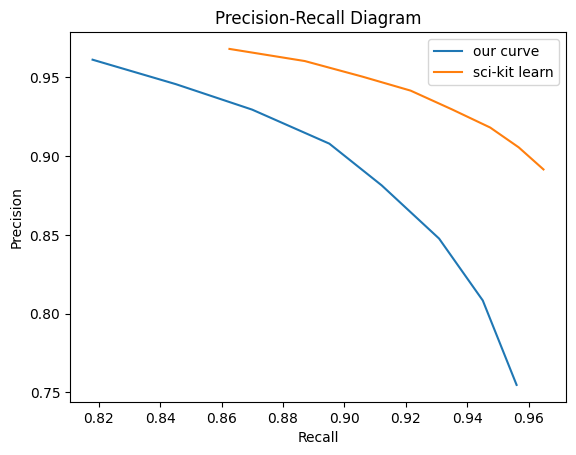

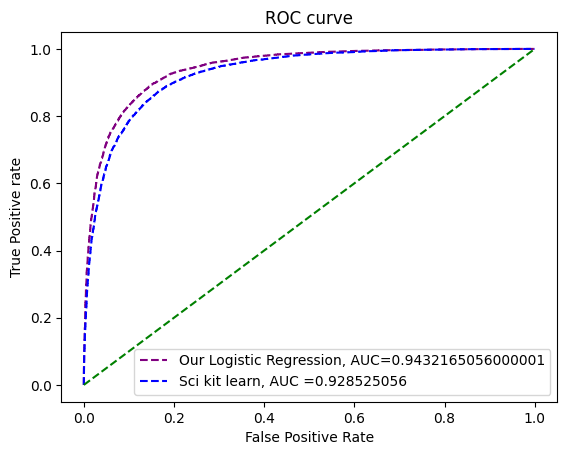

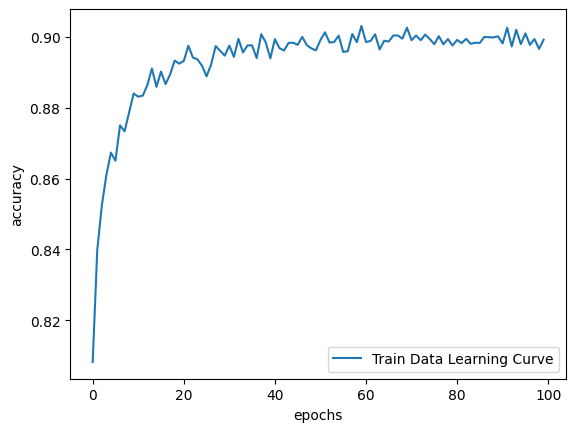

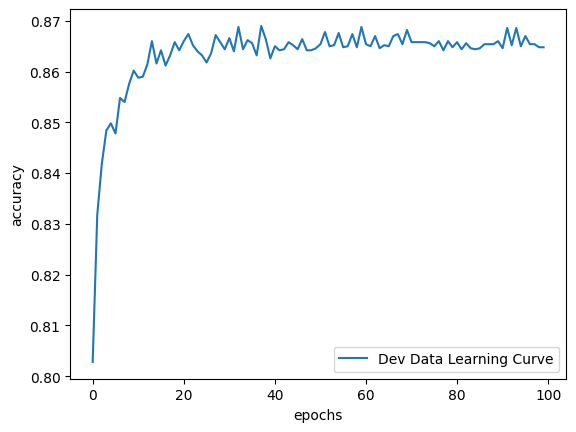

In [70]:
from sklearn.linear_model import LogisticRegression as skLogReg

LogReg1 = LogisticRegression(epochs=100,threshold=0.6, regularization_factor=0.001)
LogReg2 = skLogReg(max_iter=100)

fit_eval, train_learning_curve_data, dev_learning_curve_data = LogReg1.fit(x_train,y_train,learning_curve=True)
LogReg2.fit(x_train,y_train)


# print(LogReg1.predict_prob(x_test))
# print(LogReg2.predict_proba(x_test))
pr_curves([LogReg1, LogReg2],[x_train,y_train],size=20)
roc_curve([LogReg1,LogReg2], [x_test,y_test])
learning_curve(train_learning_curve_data, "Train Data Learning Curve")
learning_curve(dev_learning_curve_data, "Dev Data Learning Curve")
# LogReg.fit(x_train,y_train)

# classification_report(y_test,LogReg.predict(x_test))

### Part 3:
We use an rnn made with tf

In [59]:
print(x_train.shape)

model = Sequential()
model.add(Reshape((1, 3563), input_shape=(3563,)))  # Add a time step dimension
model.add(SimpleRNN(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid')) #for binary classification

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['binary_accuracy'])


#Fit the train data
model.fit(x=x_train.toarray(), y=np.array(y_train), epochs=20, verbose=1, batch_size=32, validation_split=0.2)
y_pred_proba = model.predict(x_test.toarray())
y_pred = (y_pred_proba > 0.5).astype(int)
print(classification_report(y_test,y_pred))

(25000, 3563)
Epoch 1/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3537 - binary_accuracy: 0.8497 - val_loss: 0.3117 - val_binary_accuracy: 0.8712
Epoch 2/20
625/625 [==============================] - 1s 1ms/step - loss: 0.2444 - binary_accuracy: 0.9033 - val_loss: 0.3166 - val_binary_accuracy: 0.8668
Epoch 3/20
625/625 [==============================] - 1s 1ms/step - loss: 0.2002 - binary_accuracy: 0.9208 - val_loss: 0.3306 - val_binary_accuracy: 0.8660
Epoch 4/20
625/625 [==============================] - 1s 1ms/step - loss: 0.1527 - binary_accuracy: 0.9433 - val_loss: 0.3775 - val_binary_accuracy: 0.8620
Epoch 5/20
625/625 [==============================] - 1s 1ms/step - loss: 0.1017 - binary_accuracy: 0.9669 - val_loss: 0.4171 - val_binary_accuracy: 0.8600
Epoch 6/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0604 - binary_accuracy: 0.9839 - val_loss: 0.4843 - val_binary_accuracy: 0.8622
Epoch 7/20
625/625 [==============================